# Goals for this code
- View tiff file in napari for nice visualisation
- Save each frame from tiff-file in a folder and appropraitely name them
- Iterate through the images/files in the folder and crop each of them, (looks like based on what you gave me Jonas that Fourier analysis may be the best approach?)
- Then would be nice to align these traps as I've (at least tentatively) managed to do
- But also save each cropped trap corresponding to a number in separate folders so all first traps in the file in one folder, etc. as we talked about for later
### With the fourier analysis working well, while my code works decent i think that your approach may be easier, since producing the overlay may not be needed at all? 

# View tiff file in napari
#### take tiff-file and view it in napari

In [1]:
import napari 
from skimage import io

original_tiff_image_series = "C:/Users/micha/Desktop/Master_Project/TIFF_FILES/tiff_file_converted_2.tiff"
original_image_series = io.imread(original_tiff_image_series)

viewer = napari.view_image(original_image_series, colormap='gray', name ='Original Image Series')

# Save all tiff-file frames in a folder as png
#### Note: the images feel a bit bright? not sure if that's an issue or not (see cell below)

In [85]:
import imageio
import numpy as np
from PIL import Image
import os

# Open the TIFF image file
file_path = "C:/Users/micha/Desktop/Master_Project/TIFF_FILES/tiff_file_converted.tiff"
output_folder = 'C:/Users/micha/Desktop/Mastera_Project/Original_tiff_frames'
os.makedirs(output_folder, exist_ok=True)

# Read TIFF file using imageio
tiff_frames = imageio.volread(file_path)

# Total number of frames in the TIFF file
num_frames = tiff_frames.shape[0]
print(f'Number of total frames: {num_frames}')

for frame_to_display in range(num_frames):
    # Extract Specific Frame:
    tiff_data = tiff_frames[frame_to_display]

    # Ensure the image is in uint8 format
    tiff_data = (tiff_data / np.max(tiff_data) * 255).astype(np.uint8)

    # Convert single-channel image to 3-channel image
    tiff_data_color = np.stack([tiff_data] * 3, axis=-1)

    # Flip the image 90 degrees to the right
    flipped_tiff_data = np.rot90(tiff_data_color)

    # Save the flipped TIFF frame as PNG using PIL
    output_path = os.path.join(output_folder, f'original_frame_{frame_to_display + 1}.png')
    Image.fromarray(flipped_tiff_data).save(output_path)
    print(f'Saved original frame {frame_to_display + 1} as PNG')

    # Add a separator between metadata and plots
    print("-" * 100)


Number of total frames: 392



KeyboardInterrupt



#### example image from last cell:

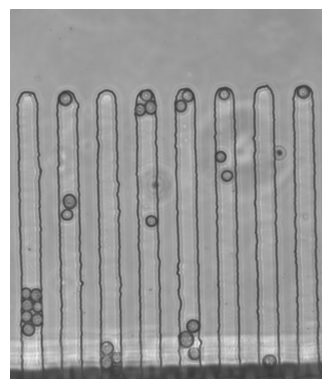

In [79]:
# Path to the PNG image
image_path = r"C:\Users\micha\Desktop\Master_Project\Original_tiff_frames\original_frame_1.png"

# Read the image using imread
image = imread(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

# Overlay for single frame
#### note: cant reproduce this overlay for all tiff images in the series and leave the the cells and traps "untouched" (as i tried to do in the cell below)

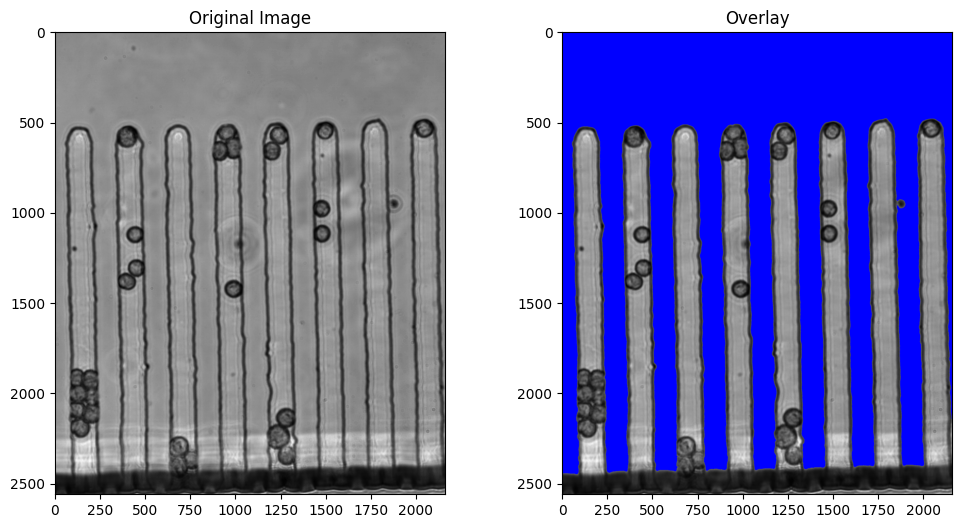

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from scipy import ndimage

# Read the image in grayscale
image_path = 'C:/Users/micha/Desktop/Master_Project/original_frame_392.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Otsu's Thresholding
_, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 2: Perform Morphological Operations (optional)
kernel = np.ones((5, 5), np.uint8)
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)  # Closing operation

# Step 3: Apply Distance Transform and Threshold
distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 3)
_, sure_fg = cv2.threshold(distance_transform, 0.7 * distance_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Step 4: Finding Sure Background
sure_bg = cv2.dilate(binary_image, kernel, iterations=3)

# Step 5: Finding Unknown Region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Step 6: Label Markers for Watershed Segmentation
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Step 7: Apply Watershed Algorithm
labels = watershed(-distance_transform, markers, mask=binary_image)

# Overlay the segmentation on the original image
overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
overlay[labels > 1] = [0, 0, 255]  # Color the segmented regions in red 
#mask 
# Save the overlay image as a PNG
cv2.imwrite('C:/Users/micha/Desktop/Master_Project/overlay_image_392.png', overlay)

# Visualize the original image and the overlay
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title('Overlay')

plt.show()


# Overlay (mask) for tiff-file (series)
### take tiff-file, produce overlay (segmenting) & save to a folder
#### note: can't get it to work nicely, would like all images to be as the one displayed in cell below (may not be relevant with the fourier transfrom?)

In [ ]:
import cv2
import numpy as np
import os
import tifffile
from skimage.segmentation import watershed

def watershed_overlay(image):
    # Convert the image to uint8
    image = (image * 255).astype(np.uint8)

    # Ensure the image has three channels
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Apply Otsu's Thresholding
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Ensure binary_image is of type CV_8UC1
    binary_image = binary_image.astype(np.uint8)

    # Step 3: Perform Morphological Operations (optional)
    kernel = np.ones((5, 5), np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)  # Closing operation

    # Step 4: Apply Distance Transform and Threshold
    distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 3)
    _, sure_fg = cv2.threshold(distance_transform, 0.7 * distance_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Step 5: Finding Sure Background
    sure_bg = cv2.dilate(binary_image, kernel, iterations=3)

    # Step 6: Finding Unknown Region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Step 7: Label Markers for Watershed Segmentation
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Step 8: Apply Watershed Algorithm
    labels = watershed(-distance_transform, markers, mask=binary_image)

    # Overlay the segmentation on the original image
    overlay = image.copy()
    overlay[labels > 1] = [0, 0, 255]  # Color the segmented regions in red

    return overlay

# Directory for saving flipped overlay images
output_folder = 'C:/Users/micha/Desktop/Master_Project/Flipped_overlay_images'
os.makedirs(output_folder, exist_ok=True)

# Open the TIFF image file and convert to grayscale
file_path = "C:/Users/micha/Desktop/Master_Project/tiff_file_converted.tiff"
with tifffile.TiffFile(file_path) as tif:
    num_frames = len(tif.pages)
    print(f'Number of total frames: {num_frames}')

    for frame_to_display in range(num_frames):
        # Extract Specific Frame
        tiff_data = tif.asarray(key=frame_to_display)

        # Perform Watershed Segmentation and get the overlay
        overlay = watershed_overlay(tiff_data)

        # Flip the overlay image 90 degrees to the right
        flipped_overlay = cv2.rotate(overlay, cv2.ROTATE_90_CLOCKWISE)

        # Save the flipped overlay image
        flipped_output_path = os.path.join(output_folder, f'flipped_overlay_image_{frame_to_display + 1}.png')
        cv2.imwrite(flipped_output_path, flipped_overlay)

        print(f'Processed frame {frame_to_display + 1}/{num_frames}')

print(f'Flipped overlay images saved to: {output_folder}')



# Crop traps
#### project intesity values along x-axis, iterate through projection and crop traps based on threshold (with a +- margin)
#### Also save coordinates for later use

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import napari

# Step 0: Read the image using an appropriate method
image_path_overlay= 'C:/Users/micha/Desktop/Master_Project/overlay_image_392_flipped.png'
image_overlay = imread(image_path_overlay)

# Convert the image to grayscale if it has three color channels
if image_thing_3.ndim == 3:
    image_thing_3 = np.mean(image_thing_3, axis=-1)  # take mean values across X-axis

# Check the shape of the image
print("Image Shape:", image_thing_3.shape)

# Step 1: Set a threshold for intensity values
threshold = 840  # Adjust the threshold based on your data
margin = 50  # Adjust the margin based on your requirement

# Step 2: Iterate through the x-axis and identify traps based on intensity values
# parameters for for-loop and cropping
traps = []
trap_started = False
current_trap = None
trap_coordinates = []

for x in range(image_thing_3.shape[1]):  # iterate over each column in the x-axis
    if image_thing_3[:, x].sum() > threshold:  # if intensity value for each column is over intensity-threshold
        if not trap_started:
            trap_started = True  # start trap
            start_x = x - margin  # start value for cropping
            current_trap = image_thing_3[:, start_x:x + 1]
        else:
            current_trap = np.hstack([current_trap, image_thing_3[:, x:x + 1]])
    else:
        if trap_started:
            end_x = x + margin
            traps.append(current_trap)
            trap_coordinates.append((start_x, end_x))
            trap_started = False  # Reset trap_started

# Ensure all arrays in traps have the same length along the second axis
max_length = max(trap.shape[1] for trap in traps)

# Adjust the traps to have the same length
traps = [np.pad(trap, ((0, 0), (0, max_length - trap.shape[1])), mode='constant') for trap in traps]

# Save trap coordinates for later use
trap_coordinates = np.array(trap_coordinates)
np.save('trap_coordinates.npy', trap_coordinates)

# Create a Napari viewer for cropped traps
viewer = napari.Viewer()

# Create a single layer with all the traps stacked on top of each other
stacked_traps = np.vstack(traps)
viewer.add_image(stacked_traps, colormap='gray', name='Stacked Traps')

# Show the Napari viewer
napari.gui_qt()


Image Shape: (2560, 2160)


C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 188) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 188) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


# Trap cropping for multiple images
### uses saved coordinates from earlier image to crop traps for files in folder (in order) and align in napari

In [77]:
import os
import numpy as np
from PIL import Image
import re
import napari

# Folder containing the images
folder_path = r'C:\Users\micha\Desktop\Master_Project\Flipped_overlay_images\tetrad_formation'  # Replace with the path to your image folder
trap_coordinates_path = 'trap_coordinates.npy'  # Replace with the path to your trap coordinates file

# Load trap coordinates
trap_coordinates = np.load(trap_coordinates_path)

# Get a list of image filenames and sort them based on numeric order
image_files = sorted([filename for filename in os.listdir(folder_path) if filename.endswith('.png')], key=lambda x: int(re.search(r'\d+', x).group()))

# Initialize a list to store vertical stacks for each image
all_vertical_stacks = []

# Iterate through each image file
for filename in image_files:
    # Read the image using PIL
    image_path = os.path.join(folder_path, filename)
    image = Image.open(image_path)

    # Convert the image to grayscale
    image_gray = image.convert('L')
    image_array = np.array(image_gray)

    # Initialize a list to store cropped traps for the current image
    traps = []

    # Iterate through trap coordinates
    for start_x, end_x in trap_coordinates:
        trap = image_array[:, start_x:end_x]
        traps.append(trap)

    # Ensure all arrays in traps have the same length along the second axis
    max_length = max(trap.shape[1] for trap in traps)
    traps = [np.pad(trap, ((0, 0), (0, max_length - trap.shape[1])), mode='constant') for trap in traps]

    # Stack the traps vertically
    vertical_stack = np.vstack(traps)

    # Append the vertical stack for the current image to the list
    all_vertical_stacks.append(vertical_stack)

# Stack the vertical stacks horizontally to create the final image
stacked_image = np.hstack(all_vertical_stacks)

# Create a Napari viewer for the stacked image
viewer = napari.Viewer()
viewer.add_image(stacked_image, colormap='gray', contrast_limits=[0, 255], name='Stacked Image')

# Show the Napari viewer
napari.gui_qt()


C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 1428) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 1428) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


# Fourier analysis
### unomdified code from the github you sent

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from imageio.v2 import imread
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
from skimage.color import rgba2rgb, rgb2gray
from skimage.util import img_as_float

In [117]:
img_file = r"C:\Users\micha\Desktop\Master_Project\Original_tiff_frames\duplication\original_frame_76.png"

In [118]:
img = imread(img_file)  # image was originally saved as RGBA (?)
img = rgb2gray(rgba2rgb(img))  # convert image to grayscale
img = img_as_float(img)  # ensure image is in 0-1 range
print(img.dtype, img.shape)

float64 (2560, 2160)


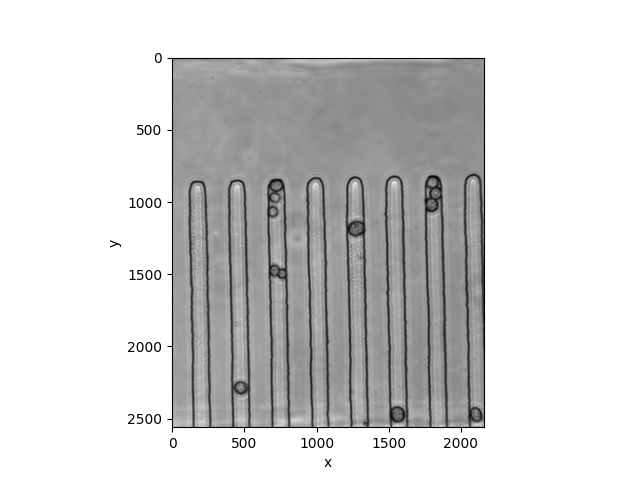

In [119]:
%matplotlib widget
fig, ax = plt.subplots()
ax.imshow(img, cmap="gray")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [120]:
# in case of co-registered time-resolved data, also (max-)project along time axis
inv_aip = 1 - np.mean(img, axis=0)  # inverted average intensity projection (AIP)

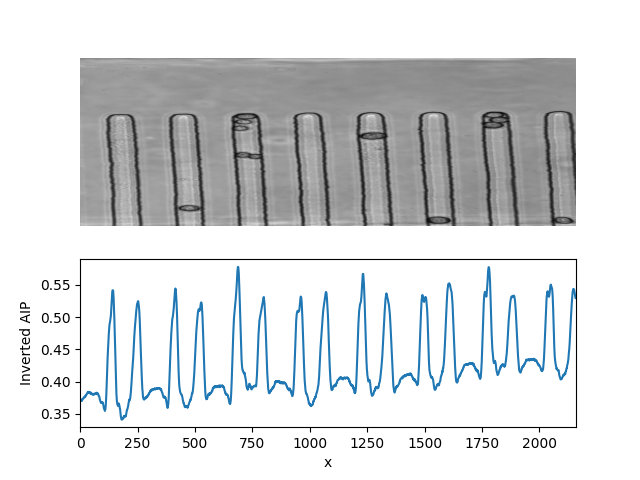

In [121]:
%matplotlib widget
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.imshow(img, cmap="gray", aspect="auto")
ax1.set_axis_off()
ax2.plot(inv_aip)
ax2.set_xlabel("x")
ax2.set_ylabel("Inverted AIP")
plt.show()

In [122]:
min_trap_width = 100
max_trap_width = 150

In [123]:
# fourier analysis
fourier = rfft(inv_aip)
freqs = rfftfreq(inv_aip.size)
magnitudes = np.abs(fourier)
# filter frequency peaks
min_freq = 1 / max_trap_width
max_freq = 1 / min_trap_width
freq_filter = (freqs >= min_freq) & (freqs <= max_freq)
filtered_freqs = freqs[freq_filter]
filtered_magnitudes = magnitudes[freq_filter]
# find highest peak within range --> trap width
max_magnitude_idx = np.argmax(filtered_magnitudes)
trap_width_freq = filtered_freqs[max_magnitude_idx]
trap_width = int(1 / trap_width_freq)
print(trap_width)

135


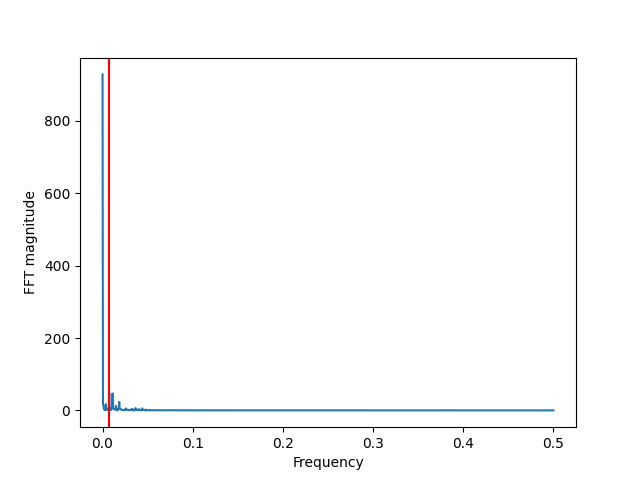

In [124]:
%matplotlib widget
fig, ax = plt.subplots()
ax.plot(freqs, magnitudes)
ax.axvline(trap_width_freq, color="red")
ax.set_xlabel("Frequency")
ax.set_ylabel("FFT magnitude")
plt.show()

In [125]:
# 1D filtering with "trap width-kernel"
ys = inv_aip[:-trap_width] + inv_aip[trap_width:]
xs = 0.5 * trap_width + np.arange(len(ys))
# find peaks --> trap centers
peaks, _ = find_peaks(ys, distance=0.8 * trap_width)
peaks = peaks[::2]  # only if trap spacing = trap width!
trap_centers = xs[peaks]
len(trap_centers)

8

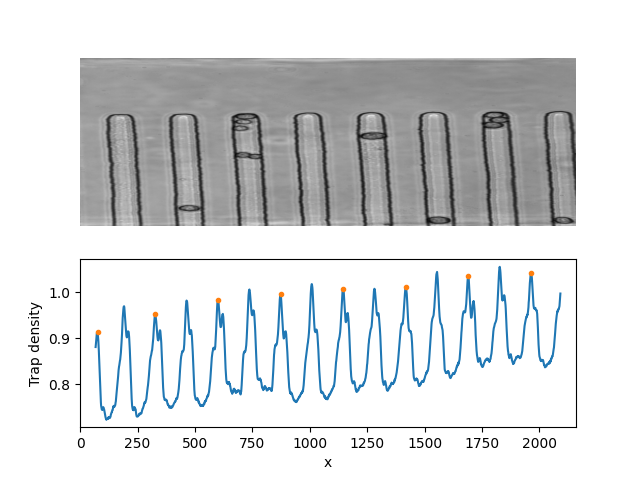

In [126]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.imshow(img, cmap="gray", aspect="auto")
ax1.set_axis_off()
ax2.plot(xs, ys)
ax2.plot(trap_centers, ys[peaks], ".")
ax2.set_xlabel("x")
ax2.set_ylabel("Trap density")
plt.show()

In [127]:
margin = 50

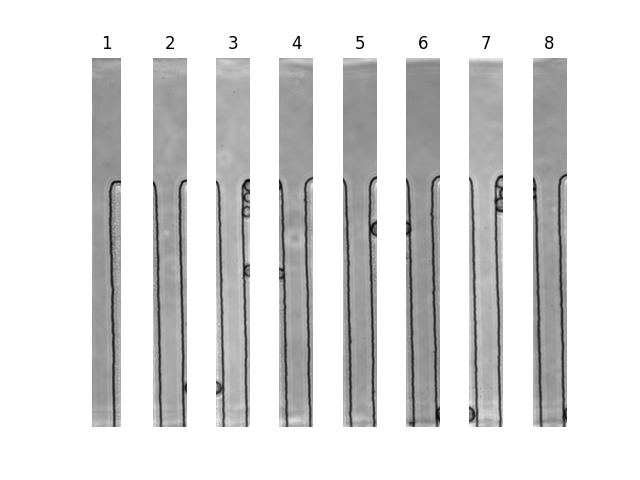

In [128]:
fig, axs = plt.subplots(ncols=len(trap_centers))
for i, (ax, trap_center) in enumerate(zip(axs, trap_centers)):
    trap_start = max(0, int(np.floor(trap_center - 0.5 * trap_width)) - margin)
    trap_end = min(img.shape[-1], int(np.ceil(trap_center + 0.5 * trap_width)) + margin)
    trap_img = img[:, trap_start:trap_end]
    ax.imshow(trap_img, cmap="gray")
    ax.set_axis_off()
    ax.set_title(i + 1)

# Napari stacking, based on Fourier analysis

In [129]:
import napari
import numpy as np
import matplotlib.pyplot as plt

# Create a Napari viewer
viewer = napari.Viewer()



# Initialize an empty list to store the padded traps
padded_traps = []
trap_starts = []
trap_ends = []

# Find the maximum width among all traps
max_trap_width = 0

# Pad each trap to have the same width
for i, trap_center in enumerate(trap_centers):
    trap_start = max(0, int(np.floor(trap_center - 0.5 * trap_width)) - margin)
    trap_end = min(img.shape[-1], int(np.ceil(trap_center + 0.5 * trap_width)) + margin)
    trap_starts.append(trap_start)
    trap_ends.append(trap_end)
    trap_img = img[:, trap_start:trap_end]

    # Update the maximum width
    max_trap_width = max(max_trap_width, trap_img.shape[1])

    # Add the trap to the list
    padded_traps.append(trap_img)

# Check if there are any traps before calculating max_trap_width
if trap_starts and trap_ends:
    max_trap_width = max(trap_end - trap_start for trap_start, trap_end in zip(trap_starts, trap_ends))

# Pad each trap to the maximum width
for i in range(len(padded_traps)):
    padded_trap = np.pad(padded_traps[i], ((0, 0), (0, max_trap_width - padded_traps[i].shape[1])), mode='constant')
    padded_traps[i] = padded_trap

# Stack the padded traps vertically
stacked_image = np.vstack(padded_traps)

# Add the stacked image as a single layer in Napari
viewer.add_image(stacked_image, colormap='gray', name='Stacked Traps')

# Show the Napari viewer
napari.gui_qt()


C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 235) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 235) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
